In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

https://ibkrcampus.com/ibkr-quant-news/hull-white-2-factor-model-2-zero-coupon-bond/

$$ r(t) = x(t)+y(t)+\phi(t) $$
$$ dx(t) = -a(t)x(t)+\sigma(t)dW_x(t) $$
$$ dy(t) = -b(t)y(t)+\eta(t)dW_y(t) $$
$$ dW_x(t)dW_y(t)=\rho dt$$

$$ x(0)=0, y(0)=0, -1 \leq \rho \leq 1 $$

$$ dx(t) = -a(t)x(t)dt + \sigma (t) dW_1(t)$$
$$ dy(t) = -b(t)y(t)dt + \eta (t) (\rho dW_1(t) + \sqrt{1-\rho^2} dW_2(t))$$

$$r(t) = \phi (t) + x(s) e ^{-\int^t_s a(v)dv} + y(s) e^{-\int^t_s b(v)dv} \newline + \int^t_s \sigma (u) e^{-\int^t_u a(v)dv}dW_1(u) \newline + \rho \int^t_s \eta (u) e^{-\int^t_u b(v)dv}dW_1(u) \newline + \sqrt{1-\rho^2} \int^t_s \eta (u) e^{-\int^t_u b(v)dv}dW_2(u)$$


$$P(t,T) = E \left[exp\left( -\int^T_t r(u)du\right) | \textit{F}_t \right]$$
$$= E \left[exp \left( -\int^T_t x(u) + y(u) + \phi(u)du \right) | \textit{F}_t \right]$$

How to solve?

$\phi(u)$ 는 determinsitic process (Not stochastic)

integrateing x(u) + y(u) from time t to T

$$r(t) = \phi (t) + x(s) e ^{-\int^t_s a(v)dv} + y(s) e^{-\int^t_s b(v)dv} \newline + \int^t_s \sigma (u) B_1(u,T)dW_1(u) \newline + \rho \int^t_s \eta (u) B_2(u,T)dW_1(u) \newline + \sqrt{1-\rho^2} \int^t_s \eta (u) B_2(u,T)dW_2(u)$$


$$B_1(t,T) = e^{-\int^t_u a(v)dv}$$
$$B_2(t,T) = e^{-\int^t_u b(v)dv}$$

$V(t,T)$ given by Ito Isometry

Nelson Siegel

선도 이자율

$$ f(\tau) = \beta_1 + \beta_2 e^{-\lambda \tau} + \beta_3 \lambda \tau e^{-\lambda \tau}$$ 

잔존만기가 $\tau$ 인 수익률

$$y(\tau)=\frac{1}{\tau} \int ^\tau_0 f(u)du$$
$$y(\tau)=\beta_1+\beta_2\left(\frac{1-e^{-\lambda \tau}}{\lambda \tau}\right)+\beta_3\left(\frac{1-e-\lambda \tau}{\lambda \tau} - e^{-\lambda\tau}\right)$$

이에 따른 수익률 곡선의 함수 형태

$$ y_t(\tau) = \beta_{1,t} + \beta_{2,t} \left(\frac{1-e^{-\lambda \tau}}{\lambda \tau}\right) + \beta_{3,t} \left(\frac{1-e-\lambda \tau}{\lambda \tau} - e^{-\lambda\tau}\right)$$

$\lambda$ 는 베타 3의 요인계수 값이 만기가 중간이면 최대값이고, 람다는 할인함수가 지수적으로 감소하는 정도를 나타낸다(exponential decay rate) 이 값이 크면, 빠르게 감소, 천천히 감소 따라서, 값이 작으면 장기 이자율에 높은 적합도

베타 1의 요인계수는 1로 만기에 변하지 않아 장기적 요소로 고려됨, 레벨 요인임

베타 2는 1부터 시작해 만기가 커지면 0으로 가므로, 단기수익률에 큰 영향 슬로프 요인

베타 3은 0에서 증가하다 다시 0감. 중기에 영향, 곡도

사후적 3요인 모델

레벨 기울기 곡도는 관측 안되므로 칼만필터 적용함.

$$y_t{\tau} = L_t + S_t + \left(\frac{1-e-\lambda \tau}{\lambda \tau}\right) + C_t\left(\frac{1-e-\lambda \tau}{\lambda \tau} - e^{-\lambda\tau}\right)$$

통상적인 칼만필터 알고리즘을 통해 추정 가능

In [2]:
import pandas as pd
import numpy as np
from pykrx import bond


In [12]:
date_list = pd.date_range('2002-01-01', '2023-03-16').strftime('%Y%m%d').to_list()

In [39]:
tickers

['국고채1년',
 '국고채3년',
 '국고채5년',
 '국고채10년',
 '국고채20년',
 '국고채30년',
 '국민주택1종5년',
 '회사채AA-',
 '회사채BBB-']

""


In [78]:
aa = bond.get_otc_treasury_yields('20020101')
tickers = aa.index.to_list()
tickers = [x.replace(' ', '') for x in tickers][:-2]

df = pd.DataFrame()
for idx in tickers:
    tmp = bond.get_otc_treasury_yields('20020101', '20230317', idx)
    tmp = tmp.iloc[:, [0]].rename(columns={'수익률':tickers})
    df[idx] = tmp
    
df = df.resample('m').last()

<AxesSubplot:xlabel='일자'>

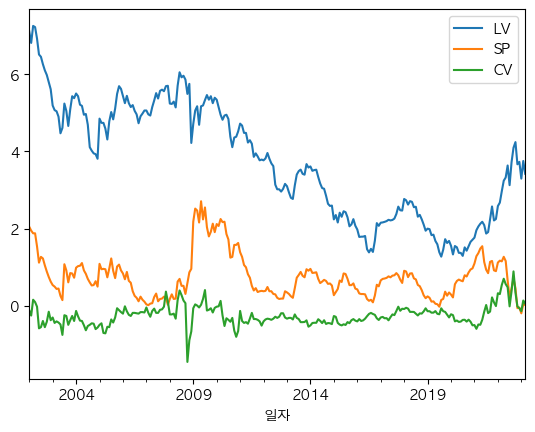

In [80]:
reg = pd.DataFrame()

reg['LV'] = df['국고채10년']
reg['SP'] = df['국고채10년'] - df['국고채1년']
reg['CV'] = df['국고채3년'] * 2 - (df['국고채1년'] + df['국고채10년'])

reg.plot()

In [84]:
X = reg.iloc[:140, :]
X_out = reg.iloc[:140, :]

In [109]:
kf_df = (X - X.mean()).rename(columns={'LV':'LV-mu',
                                       'SP':'SP-mu',
                                       'CV':'CV-mu'})
kf_df_y = (X - X.mean()).rename(columns={'LV':'LVf-mu',
                                       'SP':'SPf-mu',
                                       'CV':'CVf-mu'}).shift(-1)

pd.concat([kf_df, kf_df_y], axis=1)


,LV-mu,SP-mu,CV-mu,LVf-mu,SPf-mu,CVf-mu
일자,,,,,,
2002-01-31,2.247642,1.176857,0.165715,1.947642,1.076857,0.025714
2002-02-28,1.947642,1.076857,0.025714,2.387642,1.006857,0.435714
2002-03-31,2.387642,1.006857,0.435714,2.357642,1.006857,0.375715
2002-04-30,2.357642,1.006857,0.375715,2.057642,0.666857,0.255714
2002-05-31,2.057642,0.666857,0.255714,1.647642,0.246858,-0.304286
...,...,...,...,...,...,...
2013-04-30,-2.092358,-0.663143,-0.074286,-1.742358,-0.413143,0.055714
2013-05-31,-1.742358,-0.413143,0.055714,-1.462358,-0.143143,-0.034286
2013-06-30,-1.462358,-0.143143,-0.034286,-1.372358,-0.073143,-0.064286


In [159]:
kf_df

,LV-mu,SP-mu,CV-mu
일자,,,
2002-01-31,2.247642,1.176857,0.165715
2002-02-28,1.947642,1.076857,0.025714
2002-03-31,2.387642,1.006857,0.435714
2002-04-30,2.357642,1.006857,0.375715
2002-05-31,2.057642,0.666857,0.255714
...,...,...,...
2013-04-30,-2.092358,-0.663143,-0.074286
2013-05-31,-1.742358,-0.413143,0.055714
2013-06-30,-1.462358,-0.143143,-0.034286


<AxesSubplot:>

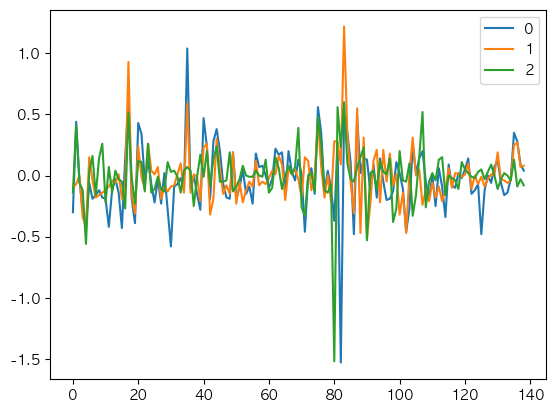

In [165]:
pd.DataFrame(kf_df_y.values - kf_df.values).iloc[:-1].plot()

<AxesSubplot:xlabel='일자'>

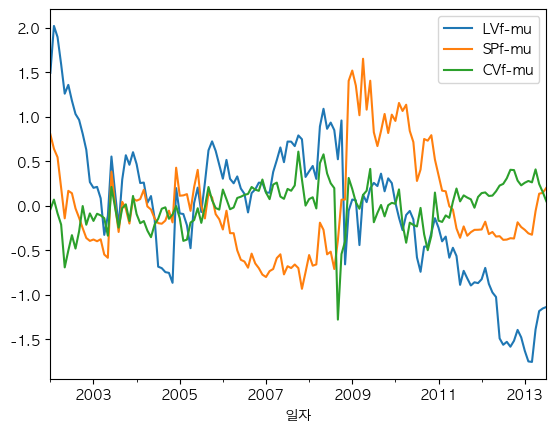

In [171]:
from pykalman import KalmanFilter

kf = KalmanFilter(\
    transition_matrices = np.ones((3,3)),
    observation_matrices = np.ones((3,3)),
    initial_state_mean = kf_df.mean(),
    initial_state_covariance = kf_df.cov(),
    observation_covariance = np.ones((3,3)),
    transition_covariance = np.ones((3,3)),
)

kf_h = kf.filter(kf_df)[0]
(kf_df_y - kf_h).iloc[:-1].plot()

<AxesSubplot:xlabel='일자'>

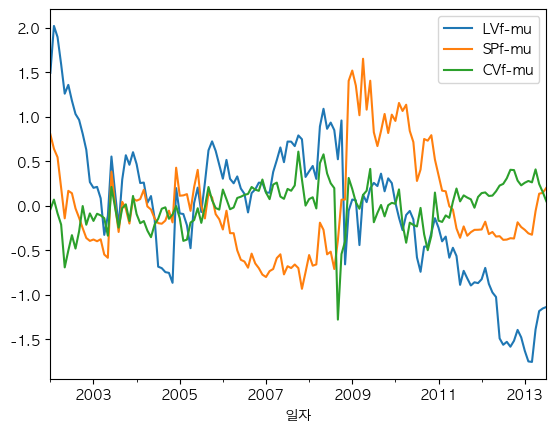

In [86]:
from pykalman import KalmanFilter

kf = KalmanFilter(transition_matrices = [1, 1, 1],
observation_matrices = [1, 1, 1],
initial_state_mean = 0,
initial_state_covariance = 1,
observation_covariance=1,
transition_covariance=.01)

state_means, _ = kf.filter(X.values)
state_means = pd.Series(state_means.flatten(), index=X.index)
state_means

ValueError: The shape of all parameters is not consistent.  Please re-check their values.

In [ ]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P